In [1]:
from utils_1551 import Corpus, load_train_and_test, text2tokens

from bpemb import BPEmb
from uk_stopwords import STOP_WORDS
from typing import List, Dict
import numpy as np
import random

In [2]:
train, test = load_train_and_test()

In [3]:
dim = 300
bpemb_ua = BPEmb(lang="uk", dim=dim)

In [4]:
print(bpemb_ua.embed('щось там').shape)
print(bpemb_ua.encode('щось там'))

(3, 300)
['▁що', 'сь', '▁там']


In [5]:
s = "Ваша відповідь:  Повідомляємо, що відповідно до п. 5.7 Державного стандарту України 4123-2006 «Пристрій примусового зниження швидкості дорожньо-транспортної техніки на вулицях і дорогах. Загальні технічні вимоги» заборонено встановлювати пристрої примусового зниження швидкості руху транспортних засобів на магістральних вулицях, а просп. Григоренка має категорію магістральної вулиці районного значення."
print(text2tokens(s))

['Ваша', 'відповідь', 'Повідомляємо', 'що', 'відповідно', 'до', 'п', '5', '7', 'Державного', 'стандарту', 'України', '4123', '2006', 'Пристрій', 'примусового', 'зниження', 'швидкості', 'дорожньо', 'транспортної', 'техніки', 'на', 'вулицях', 'і', 'дорогах', 'Загальні', 'технічні', 'вимоги', 'заборонено', 'встановлювати', 'пристрої', 'примусового', 'зниження', 'швидкості', 'руху', 'транспортних', 'засобів', 'на', 'магістральних', 'вулицях', 'а', 'просп', 'Григоренка', 'має', 'категорію', 'магістральної', 'вулиці', 'районного', 'значення']


In [6]:
def text2vec(text: str):
    res = np.zeros(dim)
    words = text2tokens(text.lower())
    for w in words:
        if w in STOP_WORDS:
            continue
        for v in bpemb_ua.embed(w):
            res += v
    res /= max(np.linalg.norm(res), 1e-6)
    return res

print(text2vec(s).shape)

(300,)


In [7]:
def corpus2xy(corpus: Corpus)->(np.array, np.array):
    x, y = [], []
    for name, messages in corpus.items():
        for id_, text in messages:
            vec = text2vec(text)
            x.append(vec)
            y.append(name)
    return np.array(x), np.array(y)

def extract_labels(corpus: Corpus)->Dict[str, int]:
    res = {name:i for i, name in enumerate(corpus.keys())}
    return res

labels_dict = extract_labels(train)
def labels_to_ind(y: np.array)->np.array:
    return np.array([labels_dict[name] for name in y])

def shuffle_xy(x: np.array, y:np.array)->(np.array, np.array):
    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    return x[p], y[p]

In [8]:
x_train, y_train = corpus2xy(train)

#print(x_train[:3])
print(y_train[:3])

['Інші-Подяки' 'Інші-Подяки' 'Інші-Подяки']


In [9]:
x_train, y_train = shuffle_xy(x_train, y_train)
#print(x_train[:3])
print(y_train[:3])

['Відсутність-ГВП'
 'Перевірка-наявності-дозволів-на-виконання-будівельних-робіт'
 'Відсутність-освітлення-на-опорних-стовпах-за-відсутності-несправності-лампочок']


In [10]:
y_train_idx = labels_to_ind(y_train)

In [11]:
print(x_train.shape, x_train.dtype)
print(y_train_idx.shape, y_train_idx.dtype)

(48120, 300) float64
(48120,) int32


In [12]:
x_test, y_test = corpus2xy(test)
y_test_idx = labels_to_ind(y_test)

In [18]:
print(x_test.shape, x_test.dtype)
print(y_test_idx.shape, y_test_idx.dtype)

(16147, 300) float64
(16147,) int32


In [13]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [19]:
one_hot_train_labels = to_categorical(y_train_idx) 
one_hot_test_labels = to_categorical(y_test_idx)

x_val = x_train[:8000]
partial_x_train = x_train[8000:]
y_val = one_hot_train_labels[:8000]
partial_y_train = one_hot_train_labels[8000:]

In [17]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(dim,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(labels_dict), activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history = model.fit(
            partial_x_train,
            partial_y_train,
            epochs=100,
            batch_size=256,
            validation_data=(x_val, y_val)
          )

Train on 40120 samples, validate on 8000 samples
Epoch 1/100
40120/40120 [==============================] - ETA: 0s - loss: 1.6833 - acc: 0.574 - ETA: 0s - loss: 1.7803 - acc: 0.523 - ETA: 0s - loss: 1.7991 - acc: 0.521 - ETA: 0s - loss: 1.8030 - acc: 0.518 - ETA: 0s - loss: 1.8134 - acc: 0.518 - ETA: 0s - loss: 1.8300 - acc: 0.515 - ETA: 0s - loss: 1.8302 - acc: 0.515 - ETA: 0s - loss: 1.8353 - acc: 0.515 - ETA: 0s - loss: 1.8413 - acc: 0.513 - ETA: 0s - loss: 1.8381 - acc: 0.513 - ETA: 0s - loss: 1.8377 - acc: 0.514 - ETA: 0s - loss: 1.8362 - acc: 0.515 - ETA: 0s - loss: 1.8360 - acc: 0.515 - ETA: 0s - loss: 1.8361 - acc: 0.516 - ETA: 0s - loss: 1.8363 - acc: 0.516 - ETA: 0s - loss: 1.8388 - acc: 0.516 - 1s 23us/sample - loss: 1.8381 - acc: 0.5159 - val_loss: 1.9650 - val_acc: 0.4920
Epoch 2/100
40120/40120 [==============================] - ETA: 1s - loss: 1.8063 - acc: 0.515 - ETA: 0s - loss: 1.8344 - acc: 0.519 - ETA: 0s - loss: 1.8371 - acc: 0.516 - ETA: 0s - loss: 1.8410 - acc: 

40120/40120 [==============================] - ETA: 1s - loss: 1.8028 - acc: 0.527 - ETA: 0s - loss: 1.7431 - acc: 0.524 - ETA: 0s - loss: 1.6850 - acc: 0.539 - ETA: 0s - loss: 1.7004 - acc: 0.538 - ETA: 0s - loss: 1.6868 - acc: 0.542 - ETA: 0s - loss: 1.6949 - acc: 0.542 - ETA: 0s - loss: 1.6922 - acc: 0.541 - ETA: 0s - loss: 1.6904 - acc: 0.542 - ETA: 0s - loss: 1.6906 - acc: 0.543 - ETA: 0s - loss: 1.6870 - acc: 0.545 - ETA: 0s - loss: 1.6850 - acc: 0.546 - ETA: 0s - loss: 1.6834 - acc: 0.546 - ETA: 0s - loss: 1.6811 - acc: 0.547 - ETA: 0s - loss: 1.6805 - acc: 0.548 - ETA: 0s - loss: 1.6805 - acc: 0.549 - ETA: 0s - loss: 1.6795 - acc: 0.549 - ETA: 0s - loss: 1.6787 - acc: 0.550 - ETA: 0s - loss: 1.6794 - acc: 0.549 - 1s 26us/sample - loss: 1.6802 - acc: 0.5498 - val_loss: 1.8644 - val_acc: 0.5104
Epoch 12/100
40120/40120 [==============================] - ETA: 1s - loss: 1.5795 - acc: 0.613 - ETA: 0s - loss: 1.6326 - acc: 0.551 - ETA: 0s - loss: 1.6278 - acc: 0.560 - ETA: 0s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.7012 - acc: 0.550 - ETA: 1s - loss: 1.5798 - acc: 0.568 - ETA: 0s - loss: 1.5435 - acc: 0.576 - ETA: 0s - loss: 1.5416 - acc: 0.580 - ETA: 0s - loss: 1.5495 - acc: 0.579 - ETA: 0s - loss: 1.5537 - acc: 0.579 - ETA: 0s - loss: 1.5467 - acc: 0.578 - ETA: 0s - loss: 1.5474 - acc: 0.580 - ETA: 0s - loss: 1.5515 - acc: 0.577 - ETA: 0s - loss: 1.5454 - acc: 0.579 - ETA: 0s - loss: 1.5496 - acc: 0.579 - ETA: 0s - loss: 1.5529 - acc: 0.578 - ETA: 0s - loss: 1.5567 - acc: 0.576 - ETA: 0s - loss: 1.5556 - acc: 0.576 - ETA: 0s - loss: 1.5602 - acc: 0.575 - ETA: 0s - loss: 1.5629 - acc: 0.574 - ETA: 0s - loss: 1.5677 - acc: 0.573 - ETA: 0s - loss: 1.5702 - acc: 0.572 - ETA: 0s - loss: 1.5713 - acc: 0.572 - ETA: 0s - loss: 1.5715 - acc: 0.572 - 1s 28us/sample - loss: 1.5721 - acc: 0.5722 - val_loss: 1.8114 - val_acc: 0.5222
Epoch 22/100
40120/40120 [==============================] - ETA: 1s - loss: 1.5598 - acc: 0.617 - ETA: 1s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.3372 - acc: 0.597 - ETA: 0s - loss: 1.4984 - acc: 0.582 - ETA: 0s - loss: 1.4788 - acc: 0.591 - ETA: 0s - loss: 1.4583 - acc: 0.598 - ETA: 0s - loss: 1.4744 - acc: 0.594 - ETA: 0s - loss: 1.4772 - acc: 0.595 - ETA: 0s - loss: 1.4792 - acc: 0.594 - ETA: 0s - loss: 1.4825 - acc: 0.594 - ETA: 0s - loss: 1.4923 - acc: 0.591 - ETA: 0s - loss: 1.4938 - acc: 0.592 - ETA: 0s - loss: 1.4967 - acc: 0.592 - ETA: 0s - loss: 1.4952 - acc: 0.591 - ETA: 0s - loss: 1.4915 - acc: 0.592 - ETA: 0s - loss: 1.4895 - acc: 0.592 - ETA: 0s - loss: 1.4942 - acc: 0.591 - ETA: 0s - loss: 1.4962 - acc: 0.590 - ETA: 0s - loss: 1.4986 - acc: 0.589 - ETA: 0s - loss: 1.4973 - acc: 0.590 - ETA: 0s - loss: 1.4979 - acc: 0.590 - 1s 27us/sample - loss: 1.4982 - acc: 0.5897 - val_loss: 1.7817 - val_acc: 0.5304
Epoch 31/100
40120/40120 [==============================] - ETA: 1s - loss: 1.5122 - acc: 0.574 - ETA: 1s - loss: 1.4965 - acc: 0.585 - ETA: 0s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.4483 - acc: 0.585 - ETA: 0s - loss: 1.3852 - acc: 0.615 - ETA: 0s - loss: 1.4360 - acc: 0.596 - ETA: 0s - loss: 1.4452 - acc: 0.596 - ETA: 0s - loss: 1.4291 - acc: 0.602 - ETA: 0s - loss: 1.4270 - acc: 0.602 - ETA: 0s - loss: 1.4305 - acc: 0.603 - ETA: 0s - loss: 1.4347 - acc: 0.604 - ETA: 0s - loss: 1.4317 - acc: 0.605 - ETA: 0s - loss: 1.4328 - acc: 0.604 - ETA: 0s - loss: 1.4424 - acc: 0.603 - ETA: 0s - loss: 1.4357 - acc: 0.604 - ETA: 0s - loss: 1.4376 - acc: 0.604 - ETA: 0s - loss: 1.4386 - acc: 0.605 - ETA: 0s - loss: 1.4370 - acc: 0.604 - ETA: 0s - loss: 1.4372 - acc: 0.603 - ETA: 0s - loss: 1.4374 - acc: 0.603 - ETA: 0s - loss: 1.4378 - acc: 0.604 - ETA: 0s - loss: 1.4416 - acc: 0.602 - 1s 28us/sample - loss: 1.4402 - acc: 0.6028 - val_loss: 1.7751 - val_acc: 0.5364
Epoch 40/100
40120/40120 [==============================] - ETA: 1s - loss: 1.5956 - acc: 0.605 - ETA: 0s - loss: 1.4491 - acc: 0.599 - ETA: 0s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.4931 - acc: 0.613 - ETA: 0s - loss: 1.3238 - acc: 0.632 - ETA: 0s - loss: 1.3465 - acc: 0.629 - ETA: 0s - loss: 1.3755 - acc: 0.621 - ETA: 0s - loss: 1.3802 - acc: 0.620 - ETA: 0s - loss: 1.3796 - acc: 0.619 - ETA: 0s - loss: 1.3690 - acc: 0.621 - ETA: 0s - loss: 1.3766 - acc: 0.619 - ETA: 0s - loss: 1.3762 - acc: 0.618 - ETA: 0s - loss: 1.3806 - acc: 0.617 - ETA: 0s - loss: 1.3844 - acc: 0.616 - ETA: 0s - loss: 1.3830 - acc: 0.616 - ETA: 0s - loss: 1.3802 - acc: 0.616 - ETA: 0s - loss: 1.3909 - acc: 0.614 - ETA: 0s - loss: 1.3923 - acc: 0.613 - ETA: 0s - loss: 1.3901 - acc: 0.613 - ETA: 0s - loss: 1.3904 - acc: 0.614 - ETA: 0s - loss: 1.3913 - acc: 0.614 - ETA: 0s - loss: 1.3898 - acc: 0.614 - ETA: 0s - loss: 1.3903 - acc: 0.614 - 1s 29us/sample - loss: 1.3889 - acc: 0.6150 - val_loss: 1.7558 - val_acc: 0.5411
Epoch 49/100
40120/40120 [==============================] - ETA: 1s - loss: 1.5826 - acc: 0.585 - ETA: 1s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.3137 - acc: 0.613 - ETA: 1s - loss: 1.2716 - acc: 0.651 - ETA: 1s - loss: 1.2632 - acc: 0.646 - ETA: 1s - loss: 1.2875 - acc: 0.640 - ETA: 0s - loss: 1.3135 - acc: 0.632 - ETA: 0s - loss: 1.3211 - acc: 0.632 - ETA: 0s - loss: 1.3266 - acc: 0.630 - ETA: 0s - loss: 1.3213 - acc: 0.630 - ETA: 0s - loss: 1.3266 - acc: 0.628 - ETA: 0s - loss: 1.3301 - acc: 0.628 - ETA: 0s - loss: 1.3295 - acc: 0.629 - ETA: 0s - loss: 1.3308 - acc: 0.629 - ETA: 0s - loss: 1.3333 - acc: 0.629 - ETA: 0s - loss: 1.3361 - acc: 0.628 - ETA: 0s - loss: 1.3413 - acc: 0.627 - ETA: 0s - loss: 1.3405 - acc: 0.627 - ETA: 0s - loss: 1.3381 - acc: 0.626 - ETA: 0s - loss: 1.3353 - acc: 0.627 - ETA: 0s - loss: 1.3393 - acc: 0.626 - ETA: 0s - loss: 1.3428 - acc: 0.625 - ETA: 0s - loss: 1.3431 - acc: 0.625 - 1s 30us/sample - loss: 1.3452 - acc: 0.6246 - val_loss: 1.7586 - val_acc: 0.5441
Epoch 58/100
40120/40120 [==============================] - ETA: 1s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.3708 - acc: 0.632 - ETA: 0s - loss: 1.3151 - acc: 0.638 - ETA: 0s - loss: 1.2895 - acc: 0.641 - ETA: 0s - loss: 1.2629 - acc: 0.642 - ETA: 0s - loss: 1.2685 - acc: 0.643 - ETA: 0s - loss: 1.2723 - acc: 0.643 - ETA: 0s - loss: 1.2780 - acc: 0.640 - ETA: 0s - loss: 1.2823 - acc: 0.638 - ETA: 0s - loss: 1.2794 - acc: 0.638 - ETA: 0s - loss: 1.2798 - acc: 0.639 - ETA: 0s - loss: 1.2807 - acc: 0.638 - ETA: 0s - loss: 1.2882 - acc: 0.636 - ETA: 0s - loss: 1.2874 - acc: 0.637 - ETA: 0s - loss: 1.2911 - acc: 0.634 - ETA: 0s - loss: 1.2932 - acc: 0.634 - ETA: 0s - loss: 1.2992 - acc: 0.633 - ETA: 0s - loss: 1.3039 - acc: 0.633 - ETA: 0s - loss: 1.3060 - acc: 0.633 - ETA: 0s - loss: 1.3066 - acc: 0.633 - 1s 27us/sample - loss: 1.3057 - acc: 0.6342 - val_loss: 1.7460 - val_acc: 0.5501
Epoch 67/100
40120/40120 [==============================] - ETA: 1s - loss: 1.3434 - acc: 0.621 - ETA: 0s - loss: 1.2945 - acc: 0.628 - ETA: 0s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.2542 - acc: 0.632 - ETA: 0s - loss: 1.2265 - acc: 0.654 - ETA: 0s - loss: 1.2566 - acc: 0.647 - ETA: 0s - loss: 1.2631 - acc: 0.646 - ETA: 0s - loss: 1.2506 - acc: 0.650 - ETA: 0s - loss: 1.2520 - acc: 0.649 - ETA: 0s - loss: 1.2649 - acc: 0.647 - ETA: 0s - loss: 1.2708 - acc: 0.644 - ETA: 0s - loss: 1.2673 - acc: 0.644 - ETA: 0s - loss: 1.2692 - acc: 0.644 - ETA: 0s - loss: 1.2674 - acc: 0.644 - ETA: 0s - loss: 1.2633 - acc: 0.645 - ETA: 0s - loss: 1.2638 - acc: 0.644 - ETA: 0s - loss: 1.2613 - acc: 0.645 - ETA: 0s - loss: 1.2615 - acc: 0.645 - ETA: 0s - loss: 1.2672 - acc: 0.643 - ETA: 0s - loss: 1.2658 - acc: 0.643 - ETA: 0s - loss: 1.2681 - acc: 0.644 - ETA: 0s - loss: 1.2674 - acc: 0.644 - ETA: 0s - loss: 1.2700 - acc: 0.644 - 1s 28us/sample - loss: 1.2706 - acc: 0.6440 - val_loss: 1.7641 - val_acc: 0.5476
Epoch 76/100
40120/40120 [==============================] - ETA: 1s - loss: 1.2303 - acc: 0.644 - ETA: 0s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.2482 - acc: 0.644 - ETA: 0s - loss: 1.2332 - acc: 0.651 - ETA: 0s - loss: 1.2269 - acc: 0.654 - ETA: 0s - loss: 1.2304 - acc: 0.654 - ETA: 0s - loss: 1.2226 - acc: 0.652 - ETA: 0s - loss: 1.2275 - acc: 0.652 - ETA: 0s - loss: 1.2240 - acc: 0.653 - ETA: 0s - loss: 1.2189 - acc: 0.654 - ETA: 0s - loss: 1.2239 - acc: 0.653 - ETA: 0s - loss: 1.2255 - acc: 0.653 - ETA: 0s - loss: 1.2220 - acc: 0.653 - ETA: 0s - loss: 1.2235 - acc: 0.653 - ETA: 0s - loss: 1.2220 - acc: 0.654 - ETA: 0s - loss: 1.2243 - acc: 0.653 - ETA: 0s - loss: 1.2273 - acc: 0.652 - ETA: 0s - loss: 1.2252 - acc: 0.653 - ETA: 0s - loss: 1.2285 - acc: 0.652 - ETA: 0s - loss: 1.2296 - acc: 0.653 - ETA: 0s - loss: 1.2293 - acc: 0.652 - ETA: 0s - loss: 1.2288 - acc: 0.652 - ETA: 0s - loss: 1.2304 - acc: 0.651 - ETA: 0s - loss: 1.2361 - acc: 0.650 - ETA: 0s - loss: 1.2355 - acc: 0.650 - 1s 33us/sample - loss: 1.2374 - acc: 0.6501 - val_loss: 1.7664 - val_acc: 0.545

40120/40120 [==============================] - ETA: 1s - loss: 1.2448 - acc: 0.656 - ETA: 0s - loss: 1.2064 - acc: 0.661 - ETA: 0s - loss: 1.1953 - acc: 0.662 - ETA: 0s - loss: 1.2114 - acc: 0.658 - ETA: 0s - loss: 1.2017 - acc: 0.662 - ETA: 0s - loss: 1.2043 - acc: 0.659 - ETA: 0s - loss: 1.2077 - acc: 0.657 - ETA: 0s - loss: 1.2105 - acc: 0.657 - ETA: 0s - loss: 1.2152 - acc: 0.656 - ETA: 0s - loss: 1.2141 - acc: 0.657 - ETA: 0s - loss: 1.2105 - acc: 0.659 - ETA: 0s - loss: 1.2103 - acc: 0.658 - ETA: 0s - loss: 1.2106 - acc: 0.658 - ETA: 0s - loss: 1.2112 - acc: 0.657 - ETA: 0s - loss: 1.2145 - acc: 0.657 - ETA: 0s - loss: 1.2146 - acc: 0.657 - ETA: 0s - loss: 1.2172 - acc: 0.655 - ETA: 0s - loss: 1.2166 - acc: 0.655 - ETA: 0s - loss: 1.2160 - acc: 0.656 - ETA: 0s - loss: 1.2143 - acc: 0.656 - ETA: 0s - loss: 1.2104 - acc: 0.657 - ETA: 0s - loss: 1.2122 - acc: 0.657 - 1s 32us/sample - loss: 1.2119 - acc: 0.6575 - val_loss: 1.7766 - val_acc: 0.5454
Epoch 93/100
40120/40120 [==========

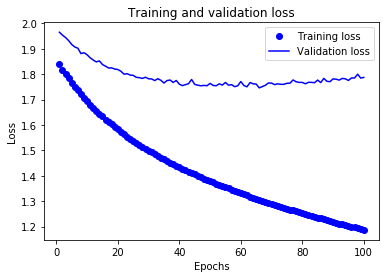

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

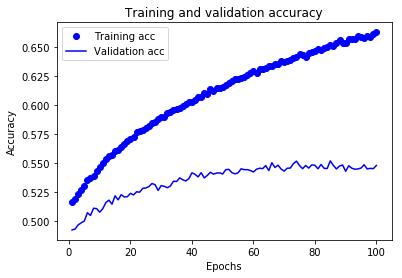

In [25]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
results = model.evaluate(x_test, one_hot_test_labels)
results

16147/16147 [==============================] - ETA: 1s - loss: 3.9950 - acc: 0.312 - ETA: 0s - loss: 2.2086 - acc: 0.477 - ETA: 0s - loss: 1.8660 - acc: 0.528 - ETA: 0s - loss: 1.4445 - acc: 0.631 - ETA: 0s - loss: 1.3646 - acc: 0.623 - ETA: 0s - loss: 1.4500 - acc: 0.606 - ETA: 0s - loss: 1.5692 - acc: 0.586 - ETA: 0s - loss: 1.5633 - acc: 0.588 - ETA: 0s - loss: 1.6827 - acc: 0.567 - ETA: 0s - loss: 1.7436 - acc: 0.558 - ETA: 0s - loss: 1.7765 - acc: 0.551 - ETA: 0s - loss: 1.7511 - acc: 0.555 - 1s 36us/sample - loss: 1.7717 - acc: 0.5516


[1.7717103467324558, 0.55161947]

In [36]:
y_pred_one_hot = model.predict(x_test)
print(y_pred_one_hot.shape)
y_pred = np.argmax(y_pred_one_hot, axis=1)
print(y_pred.shape)
print(y_pred[:5])

(16147, 188)
(16147,)
[114 125   0  89   0]


In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test_idx, y_pred))

              precision    recall  f1-score   support

           0       0.24      0.28      0.26        78
           1       0.38      0.39      0.38       182
           2       0.21      0.10      0.13        73
           3       0.58      0.74      0.65        19
           4       0.58      0.32      0.41        22
           5       0.57      0.48      0.52        25
           6       0.45      0.33      0.38        15
           7       0.60      0.73      0.66       161
           8       0.57      0.52      0.54        33
           9       0.44      0.17      0.24        24
          10       0.25      0.09      0.13        22
          11       0.44      0.67      0.53        82
          12       0.31      0.22      0.26        23
          13       0.57      0.88      0.69        34
          14       0.35      0.29      0.32        55
          15       0.27      0.19      0.22        16
          16       0.66      0.50      0.57       109
          17       0.65    